# Tutorial 1: A quickstart for Mitsuba building blocks

In [72]:
from typing import *
import numpy as np
from numpy.typing import ArrayLike
import matplotlib.pyplot as plt
%matplotlib widget

import drjit as dr
import mitsuba as mi

from util import show_ray, show_ds

-----
## 1. Random number generator: `mi.Sampler` class
A `mi.Sampler` instance can be easily understood as a random number generator.
`sampler.next_1d()` is similar to `np.random.rand()`, and `sampler.next_2d()` is similar to `np.random.rand(2)`, when `sampler` is an instance of `mi.Sampler` class.

Note that the resulting array shape for `sampler.next_1d()` and `sampler.next_2d()` are slightly depends on whether the Mitsuba variant is scalar or vectorized (CUDA or LLVM).

In [73]:
def test_sampler():
    sampler = mi.load_dict({'type': 'independent'})
    print(f"{type(sampler) = }")
    assert isinstance(sampler, mi.Sampler)
    print(sampler) # This shows some attributes for `sampler`,
                # but we have not to care about any of them now.

    val = sampler.next_1d()
    assert isinstance(val, mi.Float)
    print(f"sampler.next_1d() = {val} : {type(val)}")
    val = sampler.next_2d()
    assert isinstance(val, mi.Point2f)
    print(f"sampler.next_2d() = {val} : {type(val)}")

mi.set_variant('scalar_rgb')
print(f"#---------- {mi.variant()} ----------")
test_sampler()

mi.set_variant('cuda_ad_rgb', 'llvm_ad_rgb')
print(f"\n#---------- {mi.variant()} ----------")
test_sampler()

#---------- scalar_rgb ----------
type(sampler) = <class 'mitsuba.scalar_rgb.Sampler'>
IndependentSampler[
  base_seed = 0
  sample_count = 4
  samples_per_wavefront = 1
  wavefront_size = 0
]
sampler.next_1d() = 0.10837864875793457 : <class 'float'>
sampler.next_2d() = [0.9069600105285645, 0.4066922664642334] : <class 'mitsuba.scalar_rgb.Point2f'>

#---------- cuda_ad_rgb ----------
type(sampler) = <class 'mitsuba.cuda_ad_rgb.Sampler'>
IndependentSampler[
  base_seed = 0
  sample_count = 4
  samples_per_wavefront = 1
  wavefront_size = 0
]
sampler.next_1d() = [0.10837864875793457] : <class 'drjit.cuda.ad.Float'>
sampler.next_2d() = [[0.9069600105285645, 0.4066922664642334]] : <class 'mitsuba.cuda_ad_rgb.Point2f'>


Note that common research-oriented renderers including Mitsuba uses the deterministic pseudo-random number generator PCG32. Thus, the same seed and the number of call of `next_1d()` and `next_2d()` yields the same results.

See more:
* https://www.pcg-random.org/index.html

We first test it for a scalar variant of Mitsuba 3

In [74]:
mi.set_variant('scalar_rgb')
sampler = mi.load_dict({'type': 'independent'})

sampler.seed(1)
print("\nThe seed has been set to be 1.")
print(f"{sampler.next_1d() = }")
print(f"{sampler.next_1d() = }")
print(f"{sampler.next_1d() = }")

sampler.seed(1)
print("\nThe seed has been set to be 1.")
print(f"{sampler.next_1d() = }")
print(f"{sampler.next_1d() = }")
print(f"{sampler.next_1d() = }")


The seed has been set to be 1.
sampler.next_1d() = 0.9390237331390381
sampler.next_1d() = 0.6919573545455933
sampler.next_1d() = 0.9697715044021606

The seed has been set to be 1.
sampler.next_1d() = 0.9390237331390381
sampler.next_1d() = 0.6919573545455933
sampler.next_1d() = 0.9697715044021606


For vectorized varitans in Mitsuba 3, we should specify a parameter `wavefront_size` to call `sampler.seed()`, which indicates the amount of vectorized data.

In [75]:
mi.set_variant('cuda_ad_rgb', 'llvm_ad_rgb')
sampler = mi.load_dict({'type': 'independent'})

try:
    sampler.seed(1)
except RuntimeError as e:
    print("[ERROR OCCURED!]")
    print(e)

[ERROR OCCURED!]
​[Sampler] Sampler::seed(): wavefront_size should be specified!


In [76]:
sampler.seed(1, 1)
print("\nThe seed has been set to be 1.")
print(f"{sampler.next_1d() = }")
print(f"{sampler.next_1d() = }")
print(f"{sampler.next_1d() = }")

sampler.seed(1, 4)
print("\nThe seed has been set to be 1.")
print(f"{sampler.next_1d() = }")
print(f"{sampler.next_1d() = }")
print(f"{sampler.next_1d() = }")


The seed has been set to be 1.
sampler.next_1d() = [0.018652796745300293]
sampler.next_1d() = [0.5851906538009644]
sampler.next_1d() = [0.1382601261138916]

The seed has been set to be 1.
sampler.next_1d() = [0.018652796745300293, 0.9583619832992554, 0.7816940546035767, 0.8544584512710571]
sampler.next_1d() = [0.5851906538009644, 0.790186882019043, 0.670819878578186, 0.8393208980560303]
sampler.next_1d() = [0.1382601261138916, 0.8022022247314453, 0.23776817321777344, 0.9748337268829346]


-----
## 2. Ray intersection: `mi.Ray3f` class and `mi.Scene.ray_intersect` method
First, generate a example scene using `mi.cornell_box()`. A Mitsuba function `mi.load_dict` will convert a Python dictionary to a certain type of Mitsuba object.

See more:
* https://github.com/mitsuba-renderer/mitsuba3/blob/7d91235d5c5d5273de8011746fb480d9662181d0/src/python/python/util.py#L565

In [77]:
mi.set_variant("scalar_rgb")
# mi.set_variant("cuda_ad_rgb", "llvm_ad_rgb")

scene_dict = mi.cornell_box()
scene = mi.load_dict(scene_dict)
print(f"{type(scene) = }")

type(scene) = <class 'mitsuba.scalar_rgb.Scene'>


`mi.Ray3f` is a class for *rays*, which consist of origin points and direction vectors.

`mi.Scene.ray_intersect` method performs the ray intersection query. Note that it returns not only intersection point location, but a structure named `mi.SurfaceInteraction3f` which consists of several information of the ray intersection query.

In [78]:
print("# mi.Ray3f object")
ray = mi.Ray3f(0, (1,1,0)/np.sqrt(2))
print(f"{type(ray) = }")
print(ray)
print(ray.o)
print(ray.d)

print("\n# mi.Scene.ray_intersect method and mi.SurfaceInteraction3f object")
si = scene.ray_intersect(ray)
print(f"{type(si) = }")
assert isinstance(si, mi.SurfaceInteraction3f)

# mi.Ray3f object
type(ray) = <class 'mitsuba.scalar_rgb.Ray3f'>
Ray3f[
  o = [0, 0, 0],
  d = [0.707107, 0.707107, 0],
  maxt = 3.40282e+38,
  time = 0,
]
[0.0, 0.0, 0.0]
[0.7071067690849304, 0.7071067690849304, 0.0]

# mi.Scene.ray_intersect method and mi.SurfaceInteraction3f object
type(si) = <class 'mitsuba.scalar_rgb.SurfaceInteraction3f'>


In [79]:
print(si)

SurfaceInteraction[
  t = 1.41421,
  time = 0,
  wavelengths = [],
  p = [1, 1, 2.6054e-15],
  shape = Rectangle[
    to_world = [[-4.37114e-08, 0, -1, 1],
                [0, 1, 0, 0],
                [1, 0, -4.37114e-08, 0],
                [0, 0, 0, 1]],
    frame = Frame[
      s = [-8.74228e-08, 0, 2],
      t = [0, 2, 0],
      n = [-1, 0, -4.37114e-08]
    ],
    surface_area = 4,
    bsdf = SmoothDiffuse[
      reflectance = SRGBReflectanceSpectrum[
        value = [0.105421, 0.37798, 0.076425]
      ]
    ]
  ],
  uv = [0.5, 1],
  n = [-1, 0, -4.37114e-08],
  sh_frame = Frame[
    s = [-4.37114e-08, 0, 1],
    t = [0, 1, 0],
    n = [-1, 0, -4.37114e-08]
  ],
  dp_du = [-8.74228e-08, 0, 2],
  dp_dv = [0, 2, 0],
  wi = [3.09086e-08, -0.707107, 0.707107],
  prim_index = 0,
  instance = nullptr
]


### Visualize ray intersection
The following block visualizes a ray instance and the result of ray intersection. See also the printed text carefully. Please do not confuse that `si.wi` is written respect to the local frame of the intersection point.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


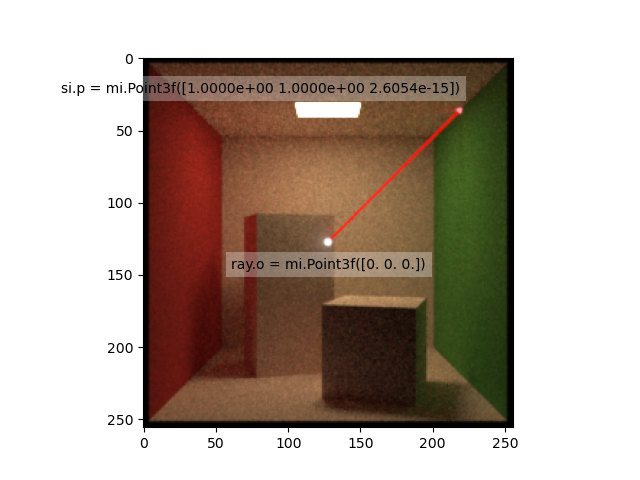

In [80]:
plt.figure()
show_ray(scene_dict, ray, si)
plt.show()

In [81]:
assert dr.allclose(si.p, ray.o + si.t * ray.d)
print("si.p == ray.o + si.t * ray.d")

assert not dr.allclose(ray.d, si.wi)
assert not dr.allclose(-ray.d, si.wi)
assert not dr.allclose(ray.d, si.sh_frame.to_world(si.wi))
assert dr.allclose(-ray.d, si.sh_frame.to_world(si.wi))
print("-ray.d == si.sh_frame.to_world(si.wi)")

si.p == ray.o + si.t * ray.d
-ray.d == si.sh_frame.to_world(si.wi)


## 3. BSDFs and their sampling: `mi.BSDF`
### `mi.BSDF` class

We can extract a BSDF object at the intersecting point as a property of the `mi.SurfaceInteraction3f` instance.

In [82]:
bsdf = si.bsdf()
print(f"{type(bsdf) = }")
assert isinstance(bsdf, mi.BSDF)
print(bsdf)

type(bsdf) = <class 'mitsuba.scalar_rgb.BSDF'>
SmoothDiffuse[
  reflectance = SRGBReflectanceSpectrum[
    value = [0.105421, 0.37798, 0.076425]
  ]
]


Important method usages:

* `bsdf.sample(ctx, si, u_1d, u_2d)` produces a random variable whose PDF is as proportional to $f_s\left(\hat\omega_i,\cdot\right)\left|\hat n \cdot \hat\omega_i\right|$ as possible. (or $f_s\left(\cdot,\hat\omega_o,\right)\left|\hat n \cdot \hat\omega_o\right|$)
* `bsdf.eval(ctx, si, wo)`$= f_s($`si.wi`$, $`wo`$)\left|\hat n \cdot \hat \omega_i\right|$
* `bsdf.pdf(ctx, si, wo)` evaluates the PDF for the sampling strategy of `bsdf.sample()`

Here, `bsdf.sample` returns not only sampled direction or BSDF value, but a 2-tuple of a `mi.BSDFSample3f` structure, which contains several information through BSDF sampling process, and a *weight* for MC integration, which is equal to:
$$
\mathtt{bsdf\_weight}=\frac{f_s\left(\hat\omega_i,\hat\omega_o\right)\left|\hat n \cdot \hat \omega_i\right|}{p\left(\hat\omega_o\mid\hat\omega_i\right)}.
$$

See the following results of the code block. Note that we do not investigate `ctx = mi.BSDFContext()` instance deeply now.

In [83]:
print("# ---------- Methods usage ----------")
ctx = mi.BSDFContext()
sampler = scene.sensors()[0].sampler()
u_1d = sampler.next_1d()
u_2d = sampler.next_2d()
bsdf_sample, bsdf_weight = bsdf.sample(ctx, si, u_1d, u_2d)

print(f"{type(bsdf_sample) = }")
assert isinstance(bsdf_sample, mi.BSDFSample3f)
print(bsdf_sample, '\n')

print(f"{type(bsdf_weight) = }")
print(bsdf_weight, '\n')

bsdf_eval, bsdf_pdf = bsdf.eval_pdf(ctx, si, bsdf_sample.wo)
print(f"{type(bsdf_eval) = }")
print(bsdf_eval, '\n')

print(f"{type(bsdf_pdf) = }")
print(bsdf_pdf, '\n')

print("# ---------- Assertions ----------")
print(f"{dr.allclose(bsdf_sample.pdf, bsdf_pdf) = }")
print(f"{dr.allclose(bsdf_weight, bsdf_eval / bsdf_pdf) = }")

# ---------- Methods usage ----------
type(bsdf_sample) = <class 'mitsuba.scalar_rgb.BSDFSample3f'>
BSDFSample[
  wo = [0.800759, -0.145777, 0.580977],
  pdf = 0.184931,
  eta = 1,
  sampled_type = TODO,
  sampled_component = 0
] 

type(bsdf_weight) = <class 'mitsuba.scalar_rgb.Color3f'>
[0.10542099922895432, 0.37797999382019043, 0.07642500102519989] 

type(bsdf_eval) = <class 'mitsuba.scalar_rgb.Color3f'>
[0.01949557662010193, 0.06990009546279907, 0.014133327640593052] 

type(bsdf_pdf) = <class 'float'>
0.184930682182312 

# ---------- Assertions ----------
dr.allclose(bsdf_sample.pdf, bsdf_pdf) = True
dr.allclose(bsdf_weight, bsdf_eval / bsdf_pdf) = True


Note that `bsdf.eval_pdf()` is just a combination of `bsdf.eval()` and `bsdf.pdf()`.

In [84]:
print(f"{dr.allclose(bsdf.pdf(ctx, si, bsdf_sample.wo), bsdf_pdf) = }")
print(f"{dr.allclose(bsdf.eval(ctx, si, bsdf_sample.wo), bsdf_eval) = }")

dr.allclose(bsdf.pdf(ctx, si, bsdf_sample.wo), bsdf_pdf) = True
dr.allclose(bsdf.eval(ctx, si, bsdf_sample.wo), bsdf_eval) = True


### Spawn ray
Once sampled refelcted (or refracted) directions for given `bsdf` at `si`, we should usually construct a new ray object with origin `si.p` and direction `bsdf_sample.wo`. In this case, using the method `mi.SurfaceInteraction3f.spawn_ray()` is more recommended than directly calling the constructor `mi.Ray3f`.

In [85]:
ray_spawn = si.spawn_ray(si.to_world(bsdf_sample.wo))
print(ray_spawn)
print(si.p)

Ray3f[
  o = [0.999821, 1, -7.8136e-12],
  d = [-0.580977, -0.145777, 0.800759],
  maxt = 3.40282e+38,
  time = 0,
]
[1.0, 0.9999999403953552, 2.605401771470185e-15]


Here, we observe that `ray_spawn.o` has a tiny offset from `si.p`. It comes from an issue of numerical computation of floating-point numbers. Refer to the following material for details.

Pharr, Matt, Wenzel Jakob, and Greg Humphreys. Physically based rendering: From theory to implementation. MIT Press, 2023.
3 Shapes - 3.9 Managing Rounding Error
https://www.pbr-book.org/3ed-2018/Shapes/Managing_Rounding_Error

### Visualize BSDF sapmling
Try the following visualization of BSDF sampling. The single red dot indicates `wi` and many blue dots indicate sampled `wo`'s. The middle plot visualizes projection of sampled direction on $xy$ plane. In the following diffuse BRDF example, the BSDF is $f_s=\frac{\rho}{\pi}$. Observe that the sampled points are uniformly distributed not in the left plot, but in the middle plot. It indicates the sampling PDF is proportional to $f_s\cdot \cos\theta$, not just $f_s$.

In the right plot, we observe that the *weight* ($f_s\cdot \cos \theta/p$) value returned by `bsdf.sample()` records constant values.

In [86]:
def bsdf_sample_statistics(N: int, si: mi.SurfaceInteraction3f, sampler: mi.Sampler
                          ) -> Tuple[np.ndarray, np.ndarray]:
    wo = np.zeros((N, 3))
    weights = np.zeros((N, 3))
    for i in range(N):
        bsdf_sample, bsdf_weight = si.bsdf().sample(ctx, si, sampler.next_1d(), sampler.next_2d())
        wo[i, :] = bsdf_sample.wo.numpy()
        weights[i, :] = bsdf_weight.numpy()
    return wo, weights

N = 10000
wo, weights = bsdf_sample_statistics(N, si, sampler)

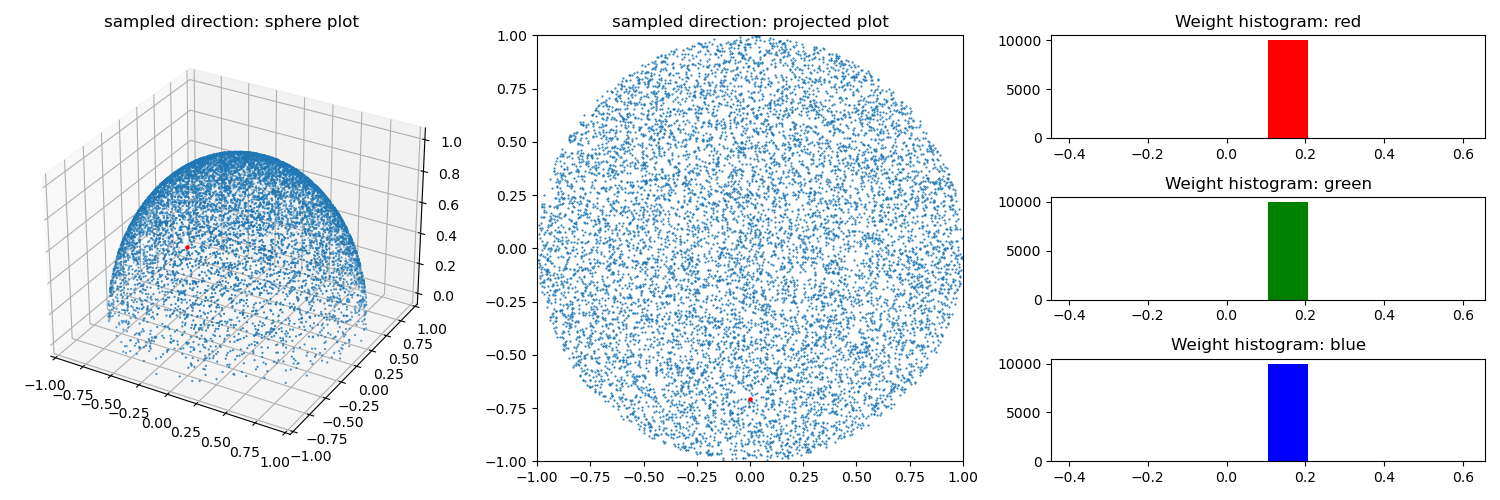

In [87]:
def plot_bsdf_samples(wos: ArrayLike, # [N, 3],
                      weights: ArrayLike, #[N, 3]
                      wi: mi.Vector3f # [3]
                     ):
    # wos = wos / np.linalg.norm(wos, axis=1, keepdims=True)
    wi = np.array(wi)
    # wi = np.array(wi) / np.linalg.norm(wi)

    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(1, 3, 1, projection='3d')
    ax.scatter(*(wos.T), s=0.3)
    ax.scatter(*(wi*1.05), s=5.0, c='red')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_title("sampled direction: sphere plot")

    ax = fig.add_subplot(1, 3, 2, aspect='equal')
    ax.scatter(*(wos.T[:2,:]), s=0.3);
    ax.scatter(*wi[:2], s=5.0, c='red')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_title("sampled direction: projected plot")

    for i,col in zip(range(3), ['red', 'green', 'blue']):
        ax = fig.add_subplot(3, 3, 3*i+3)
        ax.hist(weights[:,0], color=col)
        ax.set_title("Weight histogram: "+col)

    fig.tight_layout()
plot_bsdf_samples(wo, weights, si.wi)

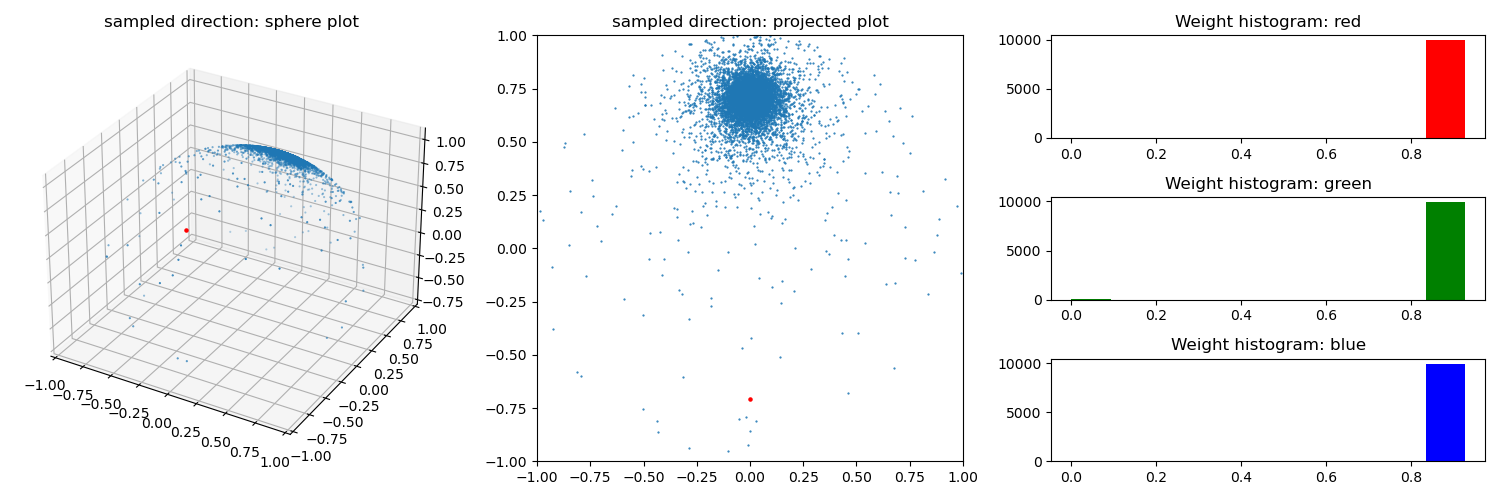

In [88]:
scene_dict = mi.cornell_box()
for key in ['white', 'green', 'red']:
    scene_dict[key] = {'type': 'roughconductor',
                       'material': 'Al',
                       'distribution': 'ggx',
                       'alpha': 0.05}
scene2 = mi.load_dict(scene_dict)

si2 = scene2.ray_intersect(ray)
wo, weights = bsdf_sample_statistics(N, si2, sampler)
plot_bsdf_samples(wo, weights, si2.wi)

However, for a `roughplastic` material, we observe that the *weight* is not constant. Note that making a sampling strategy be proportional to $f_s \cdot\cos\theta$ is desirable if possible, but not strictly mandatory. If the BSDF function is too complicate, a similar PDF is okay.

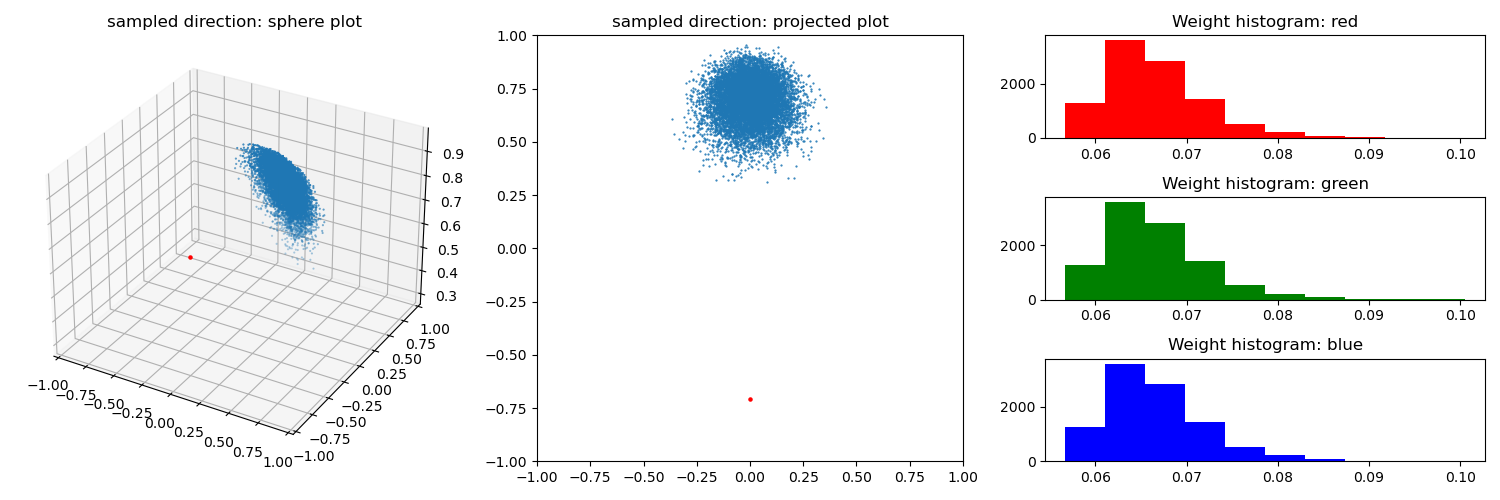

In [89]:
scene_dict = mi.cornell_box()
for key in ['white', 'green', 'red']:
    scene_dict[key] = {'type': 'roughplastic',
                       'distribution': 'beckmann',
                       'int_ior': 1.61,
                       'diffuse_reflectance': {
                            'type': 'rgb',
                            'value': 0
                       }}
scene3 = mi.load_dict(scene_dict)

si3 = scene3.ray_intersect(ray)
wo, weights = bsdf_sample_statistics(N, si3, sampler)
plot_bsdf_samples(wo, weights, si3.wi)

-----
## 4. Emitter sampling
`mi.Scene.sample_emitter_direction(self, ref, sample, test_visibility=True...)`
* **Parameter** `ref` (`mi.Interaction`)
* **Parameter** `sample` (`mi.Point2f`)
* **Parameter** `test_visibility` (`bool`) (default `True`)
* ...
* **Returns** -> `(mi.DirectionSample, mi.Spectrum)`

In [90]:
scene = mi.load_dict(mi.cornell_box())
ray = mi.Ray3f(0, [dr.sqrt(3)/2, 0.5, 0])
si = scene.ray_intersect(ray)
u = sampler.next_2d()

print("# ---------- Methods usage ----------")
ds, weight = scene.sample_emitter_direction(si, u)
print(f"{type(ds) = }")
print(ds, "\n")
print(f"{type(weight) = }")
print(f"{weight = }", "\n")

# ---------- Methods usage ----------
type(ds) = <class 'mitsuba.scalar_rgb.DirectionSample3f'>
DirectionSample3f[
  p = [-0.0947452, 0.99, 0.0303376],
  n = [0, -1, -4.37114e-08],
  uv = [0.294032, 0.55352],
  time = 0,
  pdf = 22.2228,
  delta = 0,
  emitter = AreaLight[
    radiance = SRGBReflectanceSpectrum[
      value = [18.387, 13.9873, 6.75357]
    ],
    surface_area = 0.1748,
    <no medium attached!>
  ],
  d = [-0.935418, 0.352593, 0.0259223],
  dist = 1.17033
] 

type(weight) = <class 'mitsuba.scalar_rgb.Color3f'>
weight = [0.8273916244506836, 0.6294107437133789, 0.3039020895957947] 



In [91]:
print("# ---------- Assertions ----------")
print(f"{dr.allclose(dr.norm(ds.p - si.p), ds.dist) = }")
assert not dr.allclose(si.p- ds.p, ds.dist*ds.d)
print(f"{dr.allclose(ds.p -si.p, ds.dist*ds.d) = }")
print(f"{dr.allclose(ds.pdf, scene.pdf_emitter_direction(si, ds)) = }\n")

print(f"{dr.allclose(weight, scene.eval_emitter_direction(si, ds) / ds.pdf) = }\n")

print(f"{dr.allclose(scene.eval_emitter_direction(si, ds), ds.emitter.eval_direction(si, ds)) = }")

# ---------- Assertions ----------
dr.allclose(dr.norm(ds.p - si.p), ds.dist) = True
dr.allclose(ds.p -si.p, ds.dist*ds.d) = True
dr.allclose(ds.pdf, scene.pdf_emitter_direction(si, ds)) = True

dr.allclose(weight, scene.eval_emitter_direction(si, ds) / ds.pdf) = True

dr.allclose(scene.eval_emitter_direction(si, ds), ds.emitter.eval_direction(si, ds)) = True


In [92]:
print(f"{scene.eval_emitter_direction(si, ds) = }")
print(f"{ds.emitter.eval(si) = }")
print(f"{ds.emitter.eval_direction(si, ds) = }")

scene.eval_emitter_direction(si, ds) = [18.386999130249023, 13.987299919128418, 6.753570079803467]
ds.emitter.eval(si) = [18.386999130249023, 13.987299919128418, 6.753570079803467]
ds.emitter.eval_direction(si, ds) = [18.386999130249023, 13.987299919128418, 6.753570079803467]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ds_list[0].pdf = 29.106088638305664
ds_list[0].d = [-0.9459948539733887, 0.3222646415233612, 0.03520338237285614]


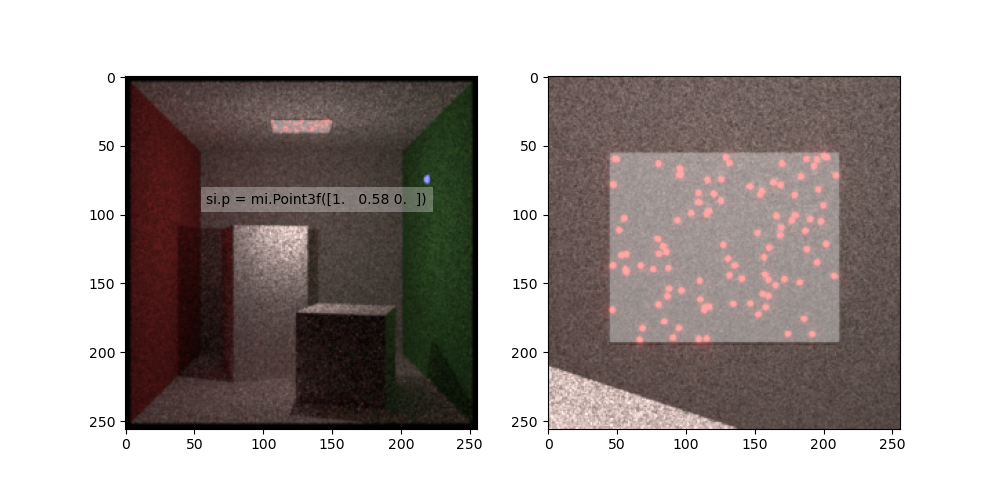

In [93]:
N = 100
ds_list = []
sampler.seed(0)
for i in range(N):
    ds_temp, _ = scene.sample_emitter_direction(si, sampler.next_2d())
    ds_list.append(ds_temp)

plt.figure(figsize=(10,5))
show_ds(si, ds_list)
print(f"{ds_list[0].pdf = }")
print(f"{ds_list[0].d = }")

Current the distribution of resulting position from `scene.sample_emitter_direction` seems not to depend on the argument `si`. However, the **pdf** which is an attribue of `mi.DirectionSample3f` is with respect to **solid angles** viewed from `ref`, so that it depends on `ref`.
Note that another some attributes of the results such as `ds.d` depend.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ds_list2[0].pdf = 6.012342929840088
ds_list2[0].d = [-0.20854206383228302, 0.9770011901855469, 0.04448496550321579]


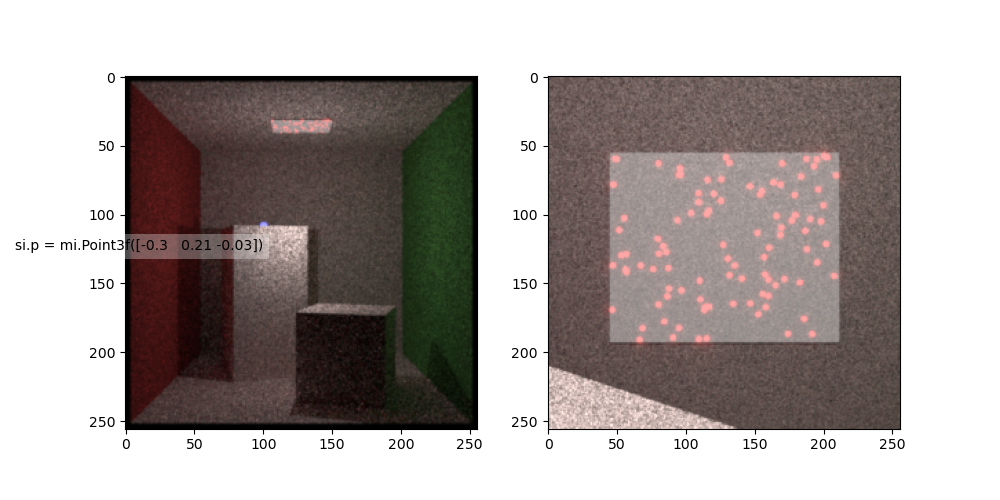

In [94]:
ray2 = mi.Ray3f([-0.3, 0.8, -0.03], [0, -1, 0])
si2 = scene.ray_intersect(ray2)
ds_list2 = []
sampler.seed(0)
for i in range(N):
    # ds_temp, _ = scene.sample_emitter_direction(si2, sampler.next_2d())
    ds_temp, _ = scene.sample_emitter_direction(mi.SurfaceInteraction3f(), sampler.next_2d())
    ds_list2.append(ds_temp)

plt.figure(figsize=(10,5))
show_ds(si2, ds_list2)
print(f"{ds_list2[0].pdf = }")
print(f"{ds_list2[0].d = }")

**Caution:** `scene.sample_emitter_direction` is not guaranteed to sample *visible* emitter point. Be careful for the `test_visibility` parameter.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


DirectionSample3f[
  p = [-0.211317, 0.99, 0.0450768],
  n = [0, -1, -4.37114e-08],
  uv = [0.0406159, 0.592307],
  time = 0,
  pdf = 0,
  delta = 0,
  emitter = AreaLight[
    radiance = SRGBReflectanceSpectrum[
      value = [18.387, 13.9873, 6.75357]
    ],
    surface_area = 0.1748,
    <no medium attached!>
  ],
  d = [0.191565, 0.980782, 0.037002],
  dist = 2.02899
]
weight3 = [0.0, 0.0, 0.0]


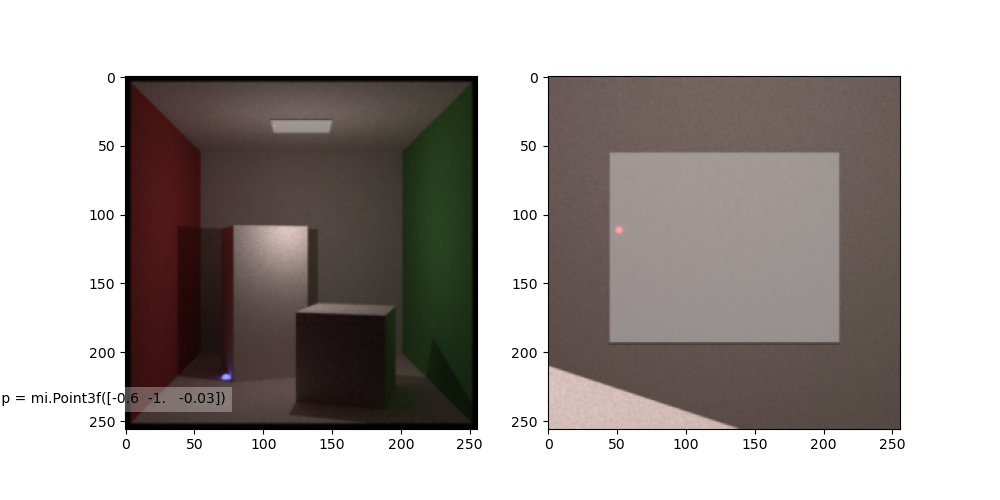

In [95]:
ray3 = mi.Ray3f([-0.6, 0.8, -0.03], [0, -1, 0])
si3 = scene.ray_intersect(ray3)
sampler.seed(0)
# Try to toggle `test_visibility`
ds3, weight3 = scene.sample_emitter_direction(si3, sampler.next_2d(), test_visibility=True)

plt.figure(figsize=(10,5))
show_ds(si3, [ds3])
print(ds3)
print(f"{weight3 = }")